


"Get an email everytime there is an earthquake" 

"Automate all the processes. To reproduce graphs"


In [1]:
import h5py
import matplotlib.pyplot as plt
# %matplotlib notebook
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
from datetime import datetime as DT

import matplotlib.dates as mdates

from dasquakes import sintela_to_datetime, open_sintela_file
from dasquakes import dt_to_utc_format, utc_to_dt_format

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client


from obspy.taup import TauPyModel
from dasquakes import get_file_number
from obspy.geodetics.base import locations2degrees

In [2]:
client = Client("IRIS")

Solving for Earthquake start time

In [3]:
def get_EQ_times(t, phase):
    t = t + datetime.timedelta(seconds = phase)
    t_of_A = dt_to_utc_format(t)
    t = t - datetime.timedelta(seconds=t.second,
                             microseconds=t.microsecond)
    return t_of_A, t

In [4]:
#Turn this into, create sation. 
def get_phase_time_UW_NOWS(t, num):
    t0 = t
    
    net = "UW"
    sta = "NOWS"
    loc = "--"
    chan = "HNN" 
    file_duration = 1
    dt = datetime.timedelta(minutes=file_duration)
    number_of_files = 2
    time = UTCDateTime(t0.strftime("%Y-%m-%dT%H:%M:%S"))
    event_time = obspy.UTCDateTime(time)
    
    t1 = UTCDateTime(  t0.strftime("%Y-%m-%dT%H:%M:%S") )
    t2 = UTCDateTime( (t0+number_of_files*dt).strftime("%Y-%m-%dT%H:%M:%S") )
    st = client.get_waveforms(net, sta, loc, chan, t1, t2, attach_response=True)
    tr = st[0]
    seedID = tr.get_id()
    cat = client.get_events(starttime = event_time - 10, endtime = event_time + 10, minmagnitude = 1)
    inv = client.get_stations(network = "UW", station = "NOWS", level = "response")
    coords = inv.get_coordinates(seedID)
    origin = cat[0].preferred_origin()
    distance = locations2degrees(origin.latitude, origin.longitude, coords["latitude"], coords["longitude"])
    
    m = TauPyModel(model = 'ak135')
    depth = origin.depth
    if depth < 0:
        depth = .001
        


    arrival = m.get_ray_paths(distance_in_degree = distance, 
                         source_depth_in_km = depth / 1000, phase_list=["S"])
    print(arrival)
   
    
    Sta_info = [net, sta]
    return arrival[num].time, arrival[num].name, tr, Sta_info

    

In [5]:
#t - time of the earthquake event in datetime.datetime format
def get_EQ(t, title):
    eq_T = t 
    title = title
    file_base_name = 'seadasn'
    pth ='/data/data0/seadasn/'

    sample_rate = 100
    file_duration = 1
    number_of_files = 3
    low_cut = 2
    hi_cut = 9
    chmin = 1
    chanmax = 1749
    dt = datetime.timedelta(minutes=file_duration)
    
    phase_arrival, phase_name, tr, sta_info = get_phase_time_UW_NOWS(eq_T, 1)
    t_of_A, t0 = get_EQ_times(eq_T, phase_arrival)
    file_number = get_file_number(pth, t0)

    data, time = open_sintela_file(file_base_name,number_of_files,
                              sample_rate,file_duration,t0,file_number,pth,dt,
                             chmin,chanmax)
    dates = sintela_to_datetime(time)
    b,a = butter(2,(low_cut, hi_cut),'bp',fs=sample_rate)
    data_filt = filtfilt(b,a,data,axis=0)


    x_lims = mdates.date2num(dates)

    fig,ax=plt.subplots(figsize=(8,8))
    plt.title(title,fontsize=12)

    ax.set_title(title)
    plt.imshow(data_filt.T,vmin=-.0005, vmax=.0005,cmap='seismic',aspect='auto',
          extent=[x_lims[0],x_lims[-1],chmin,chanmax])
    ax.xaxis_date()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(date_format)

    plt.axvline(t_of_A, color = 'r', linestyle = '-.')
    print("Showing phase arrival of " + phase_name + ' for Network:' + sta_info[0] + ' Station:' + sta_info[1])


In [6]:
# title = 'M3.4 - 25.5 km NNE from Granite Falls, WA - Tue May 17, 2022 08:07:34 (UTC)'
# eq_time = datetime.datetime(2022,5,17,8,7,34)
# #title = 'M1.8 - 4.9 km ESE from Kirkland, Wa - Thu May 19, 2022 23:49:32 (UTC)'
# #eq_time = datetime.datetime(2022,5,19,23,49,32)

/home/bjbrock/miniconda3/envs/python-obspy/lib/python3.10/site-packages/obspy/core/inventory/network.py:319: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


5 arrivals
	S phase arrival at 47.306 seconds
	S phase arrival at 47.485 seconds
	S phase arrival at 47.720 seconds
	S phase arrival at 48.628 seconds
	S phase arrival at 48.717 seconds
Showing phase arrival of S for Network:UW Station:NOWS


/home/bjbrock/miniconda3/envs/python-obspy/lib/python3.10/site-packages/obspy/core/inventory/network.py:319: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


4 arrivals
	S phase arrival at 45.802 seconds
	S phase arrival at 46.071 seconds
	S phase arrival at 47.127 seconds
	S phase arrival at 47.809 seconds
Showing phase arrival of S for Network:UW Station:NOWS


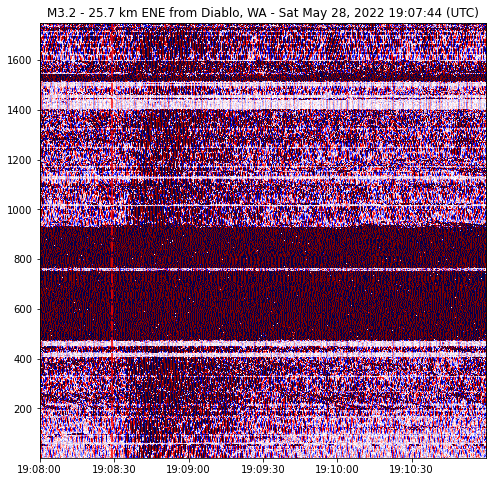

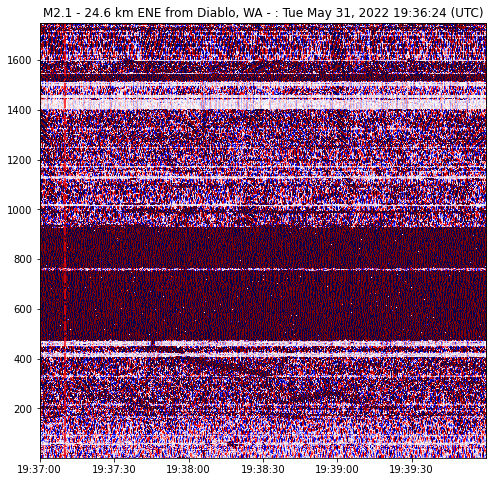

In [7]:
title = 'M3.2 - 25.7 km ENE from Diablo, WA - Sat May 28, 2022 19:07:44 (UTC)'
eq_time = datetime.datetime(2022, 5, 28, 19, 7, 42)
get_EQ(eq_time, title)

# title = 'M1.7 - 26.7 km ENE from Diablo, WA - Mon May 30, 2022 16:07:41 (UTC)'
# eq_time = datetime.datetime(2022, 5, 30, 16, 7, 41)
# get_EQ(eq_time, title)

title = 'M2.1 - 24.6 km ENE from Diablo, WA - : Tue May 31, 2022 19:36:24 (UTC)'
eq_time = datetime.datetime(2022, 5, 31, 19, 36, 24)
get_EQ(eq_time, title)

In [8]:
# title = ('M 3.5 - 247 km W of Port Orford, Oregon 2022-05-29 16:24:56')
# eq_time = datetime.datetime(2022, 5, 29, 16, 24, 56)
# get_EQ(eq_time, title)